In [1]:
#pip install joypy

In [49]:
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import multiprocessing as mp
import queue
import shelve
import pandas as pd
import seaborn as sns
from joypy import joyplot

In [50]:
from queue_function import run_queue_experiment, vary_t_worker, vary_rho_worker, expected_waiting_time, \
    tib_deterministic, tib_hyp_exponential, tib_exponential
from util import initialize_parallel_rngs

In [51]:
mpl.rcParams["figure.dpi"] = 180
mpl.rcParams["legend.fontsize"] = 12
mpl.rcParams["font.size"] = 12

plt.rc("text", usetex=True)
plt.rc("text.latex", preamble=r"""
     \usepackage{palatino}
     \usepackage{newpxmath}""")
    
plt.rc("font", family="serif")

### Helper functions

In [52]:
from scipy import stats

def sp_confidence_interval(samples, p=0.95):
    """ Calculates the confidence interval (with p=95% unless noted otherwise) 
    Returns:
         Confidence radius (int) based on samples.     
    """
    a = stats.t.interval(p, df=len(samples)-1, loc=np.mean(samples), scale=stats.sem(samples))
    return a[1] - a[0]

In [53]:
def vary_rho(seed, capacity_server, t_length=1e5, n_server=1, steps=20, n_runs=20):
    manager = mp.Manager()
    results = manager.list()
    rhos = np.linspace(0.5, 0.95, steps)
    rngs = initialize_parallel_rngs(mp.cpu_count(), seed)

    work_queue = mp.Queue()
    
    for i in range(n_runs):
        results.append(manager.list())
        for rho in rhos:
            work_queue.put((rho, i))
    
    processes = []
    for i in range(mp.cpu_count()):
        p = mp.Process(target=vary_rho_worker, args=(
            work_queue, results, rngs[i], t_length, capacity_server, n_server
        ))
        p.daemon = True
        p.start()
        processes.append(p)

    for p in processes:
        p.join()

    return  [list(t) for t in results], rhos

In [54]:
def vary_t(min_exp, max_exp, seed, arrival_rate, capacity_server, tib_func = tib_exponential, n_server=1, steps=10, n_runs=5,
           queueing_discipline="FIFO"):
    manager = mp.Manager()
    results = manager.list()
    t_range = np.logspace(min_exp, max_exp, num=((max_exp - min_exp) + 1)*steps, dtype=int)
    
    work_queue = mp.Queue()
    for i in range(n_runs):
        results.append(manager.list())
        for t in t_range:
            work_queue.put((t, i))
    
    rngs = initialize_parallel_rngs(mp.cpu_count(), seed)
    processes = []

    for i in range(mp.cpu_count()):
        p = mp.Process(target=vary_t_worker, args=(
            work_queue, results, rngs[i], arrival_rate, capacity_server, n_server, queueing_discipline, tib_func
        ))
        p.daemon = True
        p.start()
        processes.append(p)

    for p in processes:
        p.join()

    return  [list(t) for t in results], t_range

#### Varying t value

In [55]:
if False: 
    shelf = shelve.open("Arrays/t_parameter")
    vary_t_results, t_range = vary_t(min_exp=3, max_exp=6, seed=8539, arrival_rate=0.9, capacity_server=1,
                                    n_runs=50, steps=5)

    shelf["vary_t_results"] = vary_t_results
    shelf["t_range"] = t_range
    shelf.close()

In [56]:
shelf = shelve.open("Arrays/t_parameter")
vary_t_results = shelf["vary_t_results"] 
t_range = shelf["t_range"] 
shelf.close()

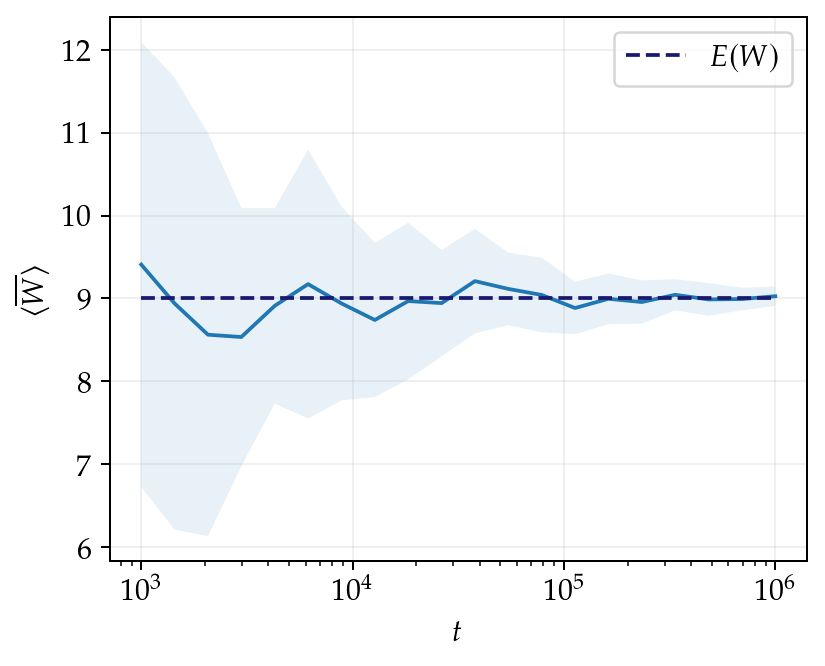

In [57]:
#Make longer and bigger (different rhos)
#And perhaps on a linear scale
fig = plt.figure(figsize=(5, 4))

results = [list(t) for t in vary_t_results]
results_means = np.mean(results, axis=0)
E_W = expected_waiting_time(0.90, 1, 1)
a = [sp_confidence_interval(samples) for samples in np.array(results).T]
plt.plot(t_range, results_means)
plt.fill_between(t_range, results_means - a, results_means + a, alpha=0.1)
plt.hlines(E_W, t_range[0], t_range[-1], label="$E(W)$", color="midnightblue", linestyles="--", zorder=3)
plt.xlabel("$t$")
plt.xscale("log")
plt.ylabel("$\\langle\\overline{W}\\rangle$")
plt.legend()
plt.grid(alpha=0.2)
plt.savefig("figures/time_paramater_choice.pdf", bbox_inches="tight")
plt.show()

#### Varying rho values

In [58]:
if False:
    shelf = shelve.open("Arrays/rho_parameter")
    varying_rho_data = []
    rhos = None

    for i, n_server in enumerate((1, 2, 4)):
        run_data, rhos_ = vary_rho(seed=2378392, capacity_server=1, t_length=1e5, n_runs=50, n_server=n_server, steps = 50)
        #run_data, rhos_ = vary_rho(seed=2378392, capacity_server=1, t_length=1e2, n_runs=50, n_server=n_server, steps = 50)
        rhos = rhos_
        varying_rho_data.append(run_data)

    shelf["vary_rho_results"] = varying_rho_data
    shelf["rhos"] = rhos
    shelf.close()

In [59]:
shelf = shelve.open("Arrays/rho_parameter")
varying_rho_data = shelf["vary_rho_results"]
rhos = shelf["rhos"] 
shelf.close()

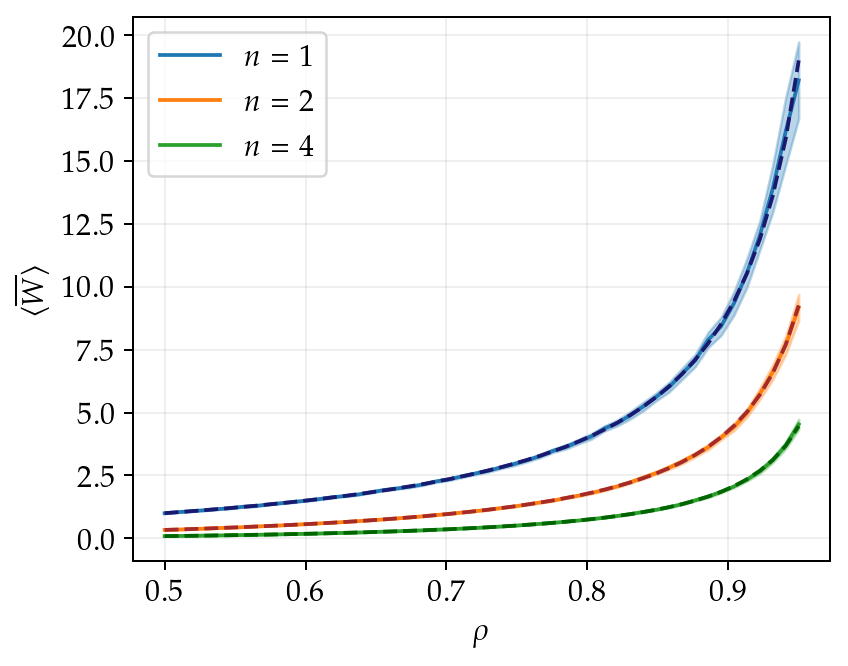

In [61]:
#Start at a later point
fig = plt.figure(figsize=(5, 4))

labels = ("$n = 1$", "$n = 2$", "$n = 4$")
colors = ("tab:blue", "tab:orange", "tab:green")
E_W_colors = ("midnightblue", "brown", "darkgreen")

for i, n_server in enumerate((1, 2, 4)):
    run_data = varying_rho_data[i]
    run_data_mean = np.mean(run_data, axis=0)
    a = [sp_confidence_interval(samples) for samples in np.array(run_data).T]
    run_data_std = np.std(run_data, axis=0, ddof=1)
    plt.plot(rhos, run_data_mean, label=labels[i], color=colors[i])
    plt.fill_between(rhos, run_data_mean - a, run_data_mean + a, alpha=0.3, color=colors[i])
    
    E_Ws = [expected_waiting_time(rho*n_server, 1, n_server) for rho in rhos]
    plt.plot(rhos, E_Ws, "--", color=E_W_colors[i])
    #plt.yscale("log")
    plt.grid(alpha=0.2)

plt.xlabel("$\\rho$")
plt.ylabel("$\\langle\\overline{W}\\rangle$")
plt.legend()
plt.savefig("figures/varying_rho_1_2_4.pdf", bbox_inches="tight")
plt.show()

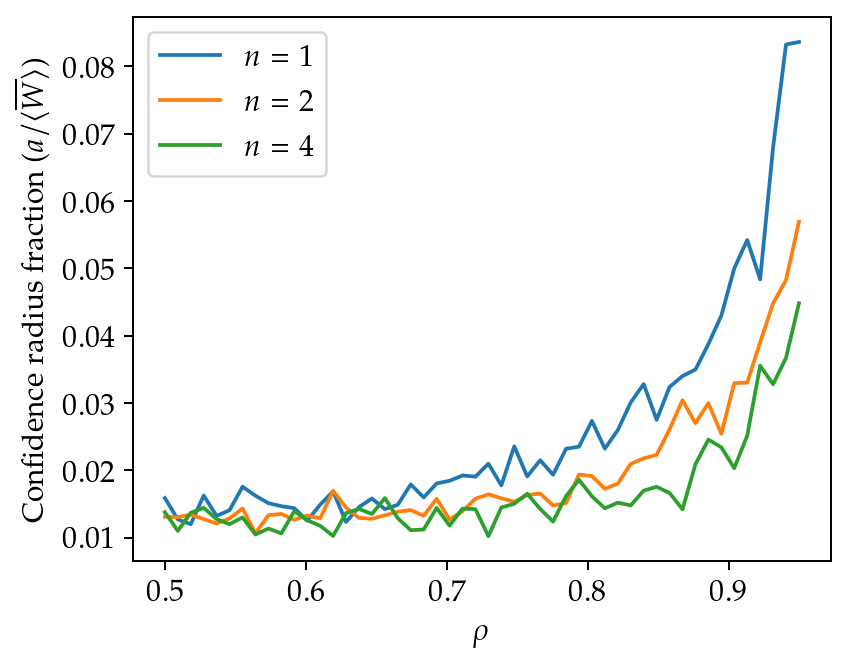

In [108]:
fig = plt.figure(figsize=(5, 4))

for i, n_server in enumerate((1, 2, 4)):
    run_data = varying_rho_data[i]
    a = [sp_confidence_interval(samples) for samples in np.array(run_data).T]
    plt.plot(rhos, a/np.mean(run_data, axis=0), label=labels[i], color=colors[i])

plt.xlabel("$\\rho$")
plt.ylabel("Confidence radius fraction ($a/\\langle\\overline{W}\\rangle$)")
plt.legend()
plt.savefig("figures/confidence_radius_fraction_rhos.pdf", bbox_inches="tight")
plt.show()

#### Comparing M/M/1 and M/M/n

In [64]:
   
if False:
    shelf = shelve.open("Arrays/stats_varying_n")

    stats_data_n1, _ = vary_t(min_exp=5, max_exp=5, seed=89253, n_server=1,
                              arrival_rate=0.9*1, capacity_server=1, steps=1, n_runs=500)
    shelf["stats_data_n1_0.90"] = sum(stats_data_n1, [])
    stats_data_n2, _ = vary_t(min_exp=5, max_exp=5, seed=11010135, n_server=2,
                              arrival_rate=0.9*2, capacity_server=1, steps=1, n_runs=500)
    shelf["stats_data_n2_0.90"] = sum(stats_data_n2, [])
    stats_data_n4, t_range = vary_t(min_exp=5, max_exp=5, seed=885302, n_server=4,
                                    arrival_rate=0.9*4, capacity_server=1, steps=1, n_runs=500)
    shelf["stats_data_n4_0.90"] = sum(stats_data_n4, [])
    
    shelf["t_range"] = t_range
    shelf.close()

In [65]:
shelf = shelve.open("Arrays/stats_varying_n")
stats_data = [shelf["stats_data_n1_0.90"], shelf["stats_data_n2_0.90"],shelf["stats_data_n4_0.90"]]
t_range = shelf["t_range"] 
shelf.close()

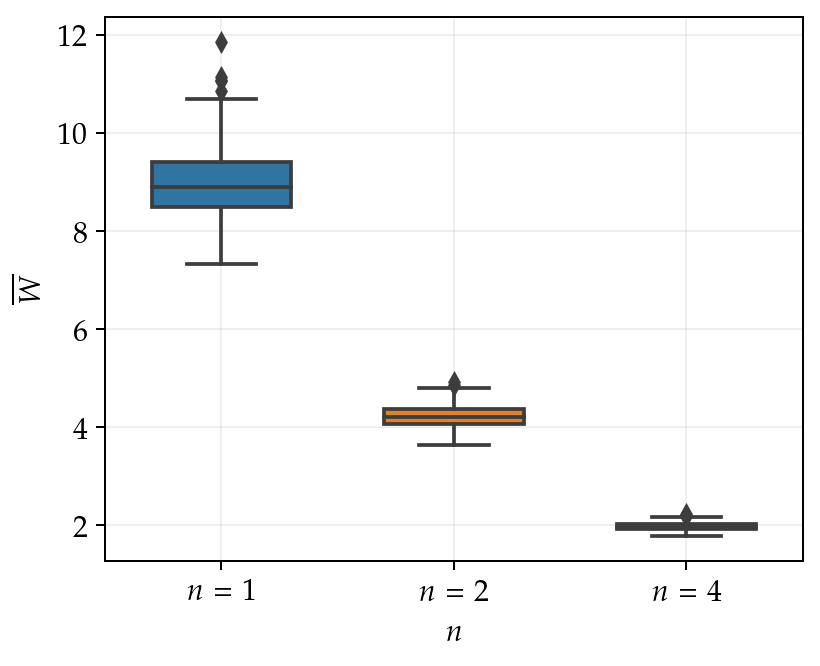

In [107]:
fig = plt.figure(figsize=(5, 4))


stats_data_n1, stats_data_n2, stats_data_n4 = stats_data 
values_n1 = np.array(stats_data_n1)
values_n2 = np.array(stats_data_n2)
values_n4 = np.array(stats_data_n4)
data_n1 = np.array([np.repeat("$n = 1$", len(values_n1)), values_n1])
data_n2 = np.array([np.repeat("$n = 2$", len(values_n2)), values_n2])
data_n3 = np.array([np.repeat("$n = 4$", len(values_n4)), values_n4])
Data = np.concatenate([data_n1, data_n2, data_n3], axis = 1)

df = pd.DataFrame(Data.T, columns = ["n", "E(W)"])
df = df.astype({"E(W)": float})
ax = sns.boxplot(x="n", y="E(W)",  data=df, width = 0.6, zorder=3)
ax.set_axisbelow(True)
plt.grid(alpha = 0.2, zorder=0)
#plt.yscale("log")
plt.ylabel("$\\overline{W}$")
plt.xlabel("$n$")
plt.savefig("figures/box_plot_1_2_4_rho0.90.pdf", bbox_inches="tight")
plt.show()

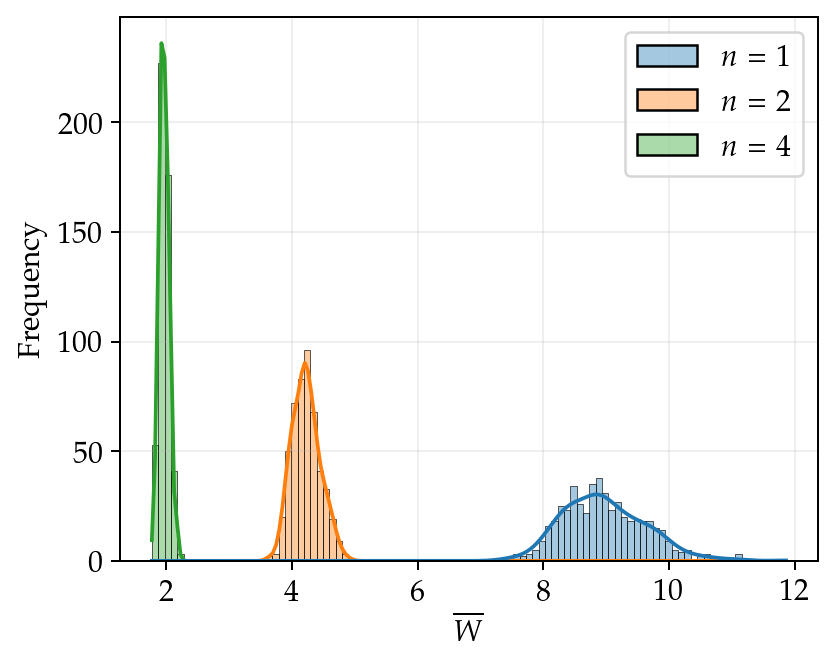

In [68]:

plt.figure(figsize = (5,4))
g = sns.histplot(data = df, hue="n", x="E(W)", alpha=0.4, kde = True, bins = 100)
g.legend_.set_title(None)
plt.grid(alpha=0.2)
plt.xlabel("$\\overline{W}$")
plt.ylabel("Frequency")
#plt.title("$\\rho = 0.90$")
plt.savefig("figures/dist_plot_1_2_4_rho0.90.pdf", bbox_inches="tight")
plt.show()

#### Comparing FIFO and SPTF

In [69]:
if False:
    shelf = shelve.open("Arrays/stats_sptf_fifo")

    sptf_stats = sum(vary_t(min_exp=5, max_exp=5, seed=1239130, n_server=1, n_runs=500,
                   arrival_rate=0.9, capacity_server=1, steps=1, queueing_discipline="SPTF")[0], [])
    shelf["sptf_stats"] = sptf_stats
    shelf.close()


In [70]:
shelf = shelve.open("Arrays/stats_sptf_fifo")
sptf_stats = shelf["sptf_stats"] 
shelf.close()

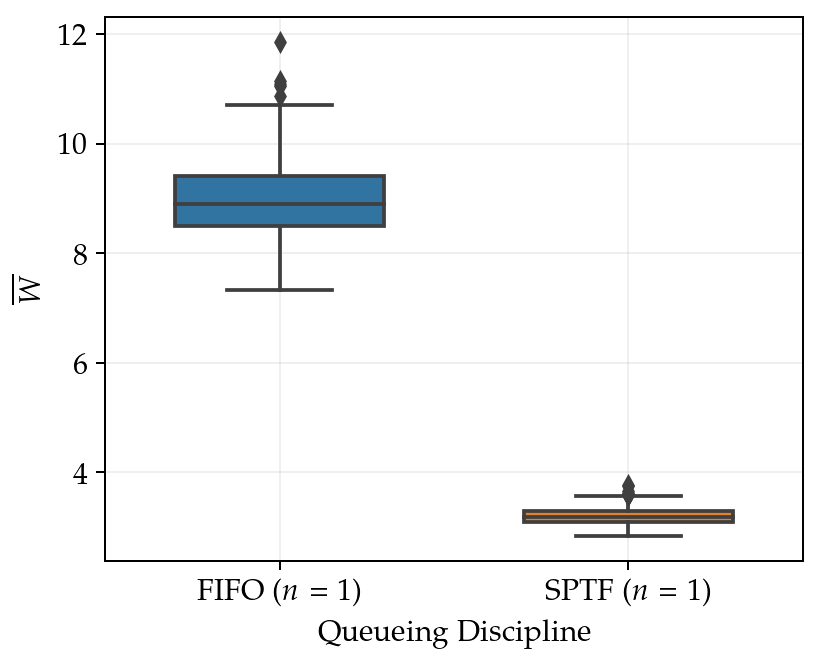

In [71]:
plt.figure(figsize = (5, 4))
values_fifo = np.array(stats_data[0])
values_sptf = np.array(sptf_stats)
data_fifo = np.array([np.repeat("FIFO ($n = 1$)", len(values_fifo)), values_fifo])
data_sptf = np.array([np.repeat("SPTF ($n = 1$)", len(values_sptf)), values_sptf])
data_fifo_sptf = np.concatenate([data_fifo, data_sptf], axis = 1)

df_fifo_sptf = pd.DataFrame(data_fifo_sptf.T, columns = ["Queueing Discipline", "W"])
df_fifo_sptf = df_fifo_sptf.astype({"W": float})
ax = sns.boxplot(x="Queueing Discipline", y="W",  data=df_fifo_sptf, width = 0.6, zorder=3)
ax.set_axisbelow(True)
plt.grid(alpha = 0.2, zorder=0)
#plt.title(f"rho = {rho}")
#plt.yscale("log")
plt.ylabel("$\\overline{W}$")
plt.xlabel("Queueing Discipline")
plt.savefig("figures/fifo_vs_sptf_boxplot.pdf", bbox_inches="tight")
plt.show()

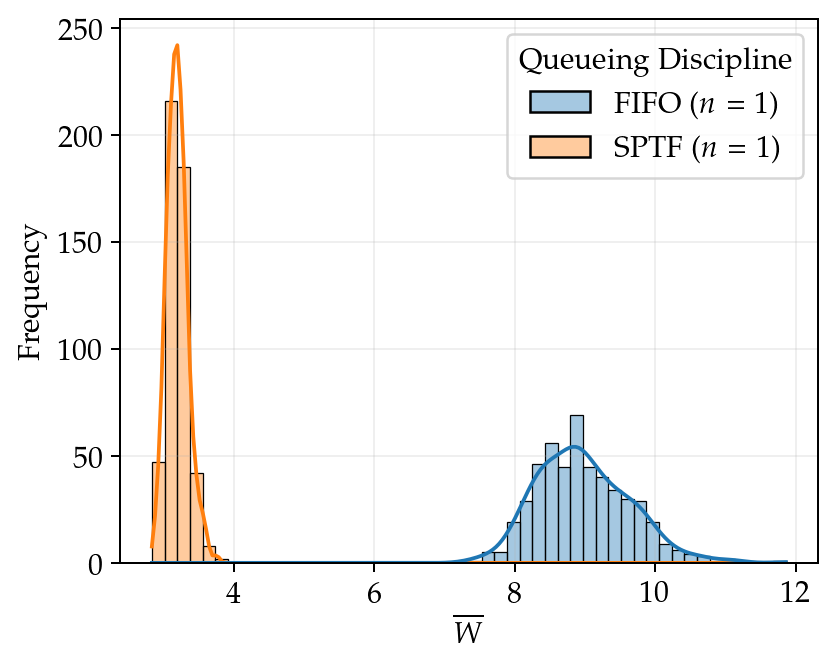

In [72]:
plt.figure(figsize = (5, 4))
sns.histplot(data = df_fifo_sptf, hue="Queueing Discipline", x="W", alpha=0.4, kde = True, bins=50)
plt.grid(alpha=0.2)
plt.xlabel("$\\overline{W}$")
plt.ylabel("Frequency")
plt.savefig("figures/fifo_vs_sptf_dist.pdf", bbox_inches="tight")
plt.show()

#### Different service distributions

In [73]:
if False:
    shelf = shelve.open("Arrays/stats_varying_n")

    stats_data_md1, _ = vary_t(min_exp=5, max_exp=5, seed=456894, n_server=1,
                              arrival_rate=0.9*1, capacity_server=1, steps=1, n_runs=500, tib_func=tib_deterministic)
    shelf["stats_data_md1"] = sum(stats_data_md1, [])
    stats_data_md2, _ = vary_t(min_exp=5, max_exp=5, seed=929834, n_server=2,
                              arrival_rate=0.9*2, capacity_server=1, steps=1, n_runs=500, tib_func=tib_deterministic)
    shelf["stats_data_md2"] = sum(stats_data_md2, [])
    stats_data_md4, t_range = vary_t(min_exp=5, max_exp=5, seed=123, n_server=4,
                                    arrival_rate=0.9*4, capacity_server=1, steps=1, n_runs=500, tib_func=tib_deterministic)
    shelf["stats_data_md4"] = sum(stats_data_md4, [])
    
    shelf["t_range"] = t_range
    shelf.close()
    
if False:
    shelf = shelve.open("Arrays/stats_varying_n")

    stats_data_mh1, _ = vary_t(min_exp=5, max_exp=5, seed=456894, n_server=1,
                              arrival_rate=0.9*1, capacity_server=0.8, steps=1, n_runs=500, tib_func=tib_hyp_exponential)
    shelf["stats_data_mh1"] = sum(stats_data_mh1, [])
    stats_data_mh2, _ = vary_t(min_exp=5, max_exp=5, seed=34345, n_server=2,
                              arrival_rate=0.9*2, capacity_server=0.8, steps=1, n_runs=500, tib_func=tib_hyp_exponential)
    shelf["stats_data_mh2"] = sum(stats_data_mh2, [])
    stats_data_mh4, t_range = vary_t(min_exp=5, max_exp=5, seed=23423, n_server=4,
                                    arrival_rate=0.9*4, capacity_server=0.8, steps=1, n_runs=500, tib_func=tib_hyp_exponential)
    shelf["stats_data_mh4"] = sum(stats_data_mh4, [])
    
    shelf["t_range"] = t_range
    shelf.close()

In [74]:
shelf = shelve.open("Arrays/stats_varying_n")
stats_data_dict = {}

stats_data_dict["mm1"] =  shelf["stats_data_n1_0.90"]
stats_data_dict["mm2"] =  shelf["stats_data_n2_0.90"]
stats_data_dict["mm4"] =  shelf["stats_data_n4_0.90"]

stats_data_dict["md1"] =  shelf["stats_data_md1"]
stats_data_dict["md2"] =  shelf["stats_data_md2"]
stats_data_dict["md4"] =  shelf["stats_data_md4"]

stats_data_dict["mh1"] =  shelf["stats_data_mh1"]
stats_data_dict["mh2"] =  shelf["stats_data_mh2"]
stats_data_dict["mh4"] =  shelf["stats_data_mh4"]
t_range = shelf["t_range"] 

shelf.close()

<Figure size 1080x720 with 0 Axes>

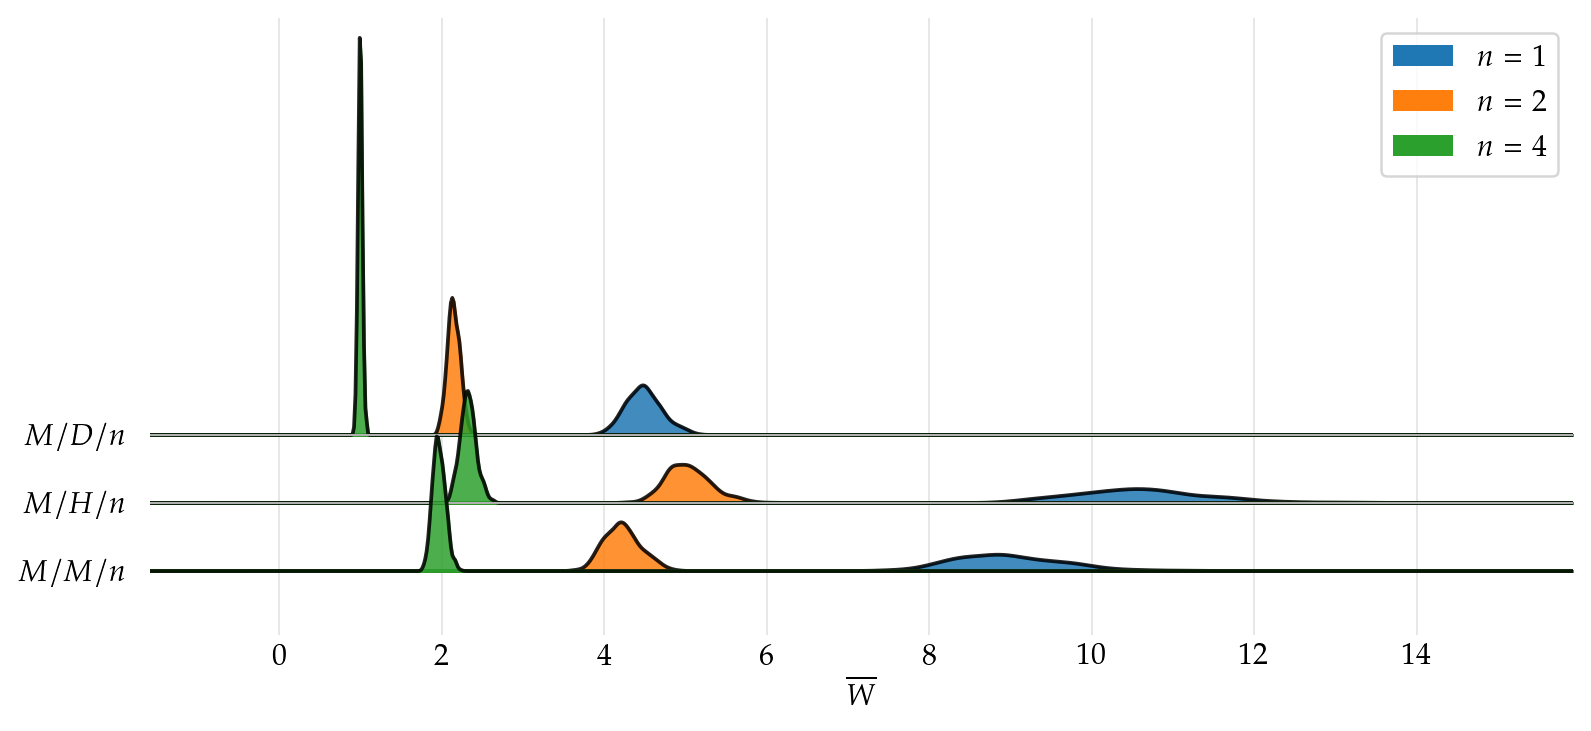

In [105]:

data_exp = np.array([np.repeat("$M/M/n$", len(stats_data_dict["mm1"])), stats_data_dict["mm1"], stats_data_dict["mm2"], stats_data_dict["mm4"]])
data_det = np.array([np.repeat("$M/D/n$", len(stats_data_dict["md1"])), stats_data_dict["md1"], stats_data_dict["md2"], stats_data_dict["md4"]])
data_hyp = np.array([np.repeat("$M/H/n$",  len(stats_data_dict["mh1"])), stats_data_dict["mh1"], stats_data_dict["mh2"], stats_data_dict["mh4"]])
Data = np.concatenate([data_exp, data_det, data_hyp], axis = 1)

df = pd.DataFrame(Data.T, columns = ["Service time Distribution", "$n=1$", "$n=2$", "$n=4$" ])
df = df.astype({"$n=1$": float})
df = df.astype({"$n=2$": float})
df = df.astype({"$n=4$": float})
#display(df)

plt.figure()
ax, fig = joyplot(
    data=df[["Service time Distribution", '$n=1$', '$n=2$', '$n=4$']], 
    by="Service time Distribution",
    column=['$n=1$', '$n=2$', '$n=4$'],
    color=["tab:blue", "tab:orange", "tab:green"],
    legend=True,
    alpha=0.85,
    overlap=2.75,
    figsize=(9, 4),
    #hist=True,
    #bins = 200,
    grid=True,
)
plt.grid(alpha=0.3)
plt.xlabel('$\\overline{W}$', fontsize=12)
plt.savefig("figures/joyplot_exp_det_hyp.pdf", bbox_inches="tight")
plt.show()